### Ex3.6: Histogram equalization
Compute the gray level (luminance) histogram for an image and equalize it so that the tones look better (and the image is less sensitive to exposure settings).

In [1]:
# import 
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# draw function:
def plt_show(title,img,cmap = None):
    fig = plt.figure()
    plt.imshow(img,cmap = cmap)
    plt.title(title)
    plt.show()
def cv_show(title,img):
    cv2.imshow(title,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
# int to uint8
def int2uint(array):
    index = np.where(array>255)
    array[index] = 255
    array = array.astype('uint8')
    return array

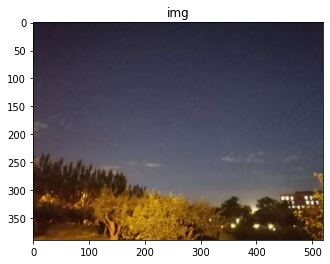

In [4]:
# load img:
img_name = "star.jpg"
img = cv2.imread(img_name)

# color img:
img_color = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt_show("img",img_color)

#### Q1: Convert the color image to luminance (Section3.1.2).
- way1: <br>
apply `cv2.COLOR_BGR2GRAY`
- way2: <br>
`luminance Y' = 0.299R'+0.587G'+0.114B'` (2.112) <br>
where Y' is gamma compressed.

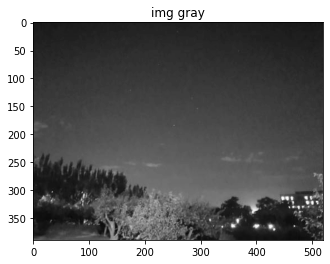

In [5]:
# convert the color image to luminance
# way1:
img_gray_1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt_show("img gray",img_gray_1,"gray")

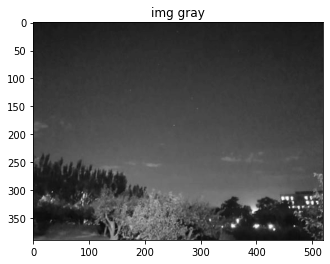

In [6]:
# convert the color image to luminance
# way2:
B,G,R = img[:,:,0].astype('int'),img[:,:,1].astype('int'),img[:,:,2].astype('int')
img_gray_2 = 0.299*R+0.587*G+0.114*B
img_gray_2 = int2uint(img_gray_2)
plt_show("img gray",img_gray_2,"gray")

In [7]:
# differences:
print("Differences between two ways:")
print(abs(img_gray_2.astype('int') -img_gray_1.astype('int')))
print("gap > 1:")
print(np.where(abs(img_gray_2.astype('int') -img_gray_1.astype('int')>1)))

Differences between two ways:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 1 1]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 1 0 1]]
gap > 1:
(array([], dtype=int64), array([], dtype=int64))


It seems that there is **no distinct gaps** between the two results.<br>
So I choose the **first method(cv2.COLOR_BGR2GRAY)** to convert color img to luminance randomly.

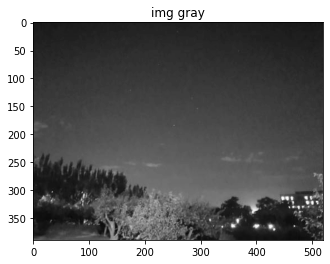

In [8]:
# select cv2.COLOR_BGR2GRAY
img_gray = img_gray_1
plt_show("img gray",img_gray,cmap="gray")

#### Q2: Compute the histogram, the cumulative distribution, and the compensation transfer function(Section 3.1.4).
---

##### Histogram:
- way1:<br>
`cv2.calcHist([img_gray],[0],None,[256],[0,256])`
- way2:<br>
To measure a histogram:<br>
For B-bit image, initialize 2^B counters with 0. In this case, we use `2^8 = 256` counters. <br>
Loop over all pixels x,y <br>
When encountering gray level `f[x,y]=i`, increment counter. 

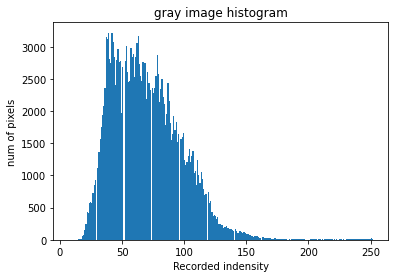

In [9]:
# compute the histogram 
# way1:
hist = cv2.calcHist([img_gray],[0],None,[256],[0,256]) # shape = (256,)
plt.hist(img_gray.ravel(),256)
plt.title("gray image histogram")
plt.xlabel("Recorded indensity")
plt.ylabel("num of pixels")
plt.show()

In [10]:
# Compute Histogram:
# way2:
def Histogram(img_gray):
    hist = np.zeros((256,),dtype='int')
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            hist[img_gray[i][j]]+=1
    return hist

In [11]:
hist = Histogram(img_gray) # shape = (256,)

Text(0, 0.5, 'pixels')

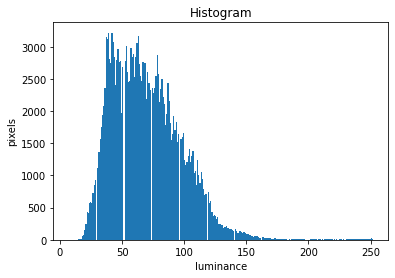

In [12]:
# draw
_ = plt.hist(img_gray.ravel(),256)
plt.title("Histogram")
plt.xlabel("luminance")
plt.ylabel("pixels")

##### Cumulative distribution:
```
C(I) = 1/N*sum(h(i)) = C(I-1)+1/N*h(I) where i = 0 to I.
```
where **N** is the number of pixels in the image, and **i/I** is the luminance of a pixel. **h(i)** represents the luminance value's corresponding percentile.

In [13]:
# calculate CDF: C(I) = 1/N*sum(0,I)h(i)
def CDF_fun(hist,i):
    return np.sum(hist[0:i])/np.sum(hist)
    
def CDF(hist):
    sum = np.sum(hist)
    cdf = []
    for i in range(0,256):
        cdf.append(np.sum(hist[0:i])/sum)
    plt.plot(np.arange(0,256),cdf)
    plt.title("CDF")
    plt.show()
    return np.array(cdf)

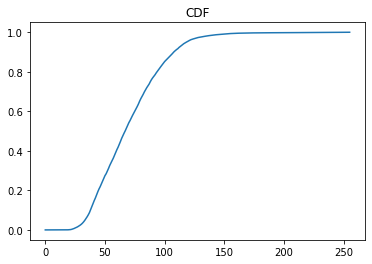

In [14]:
cdf = CDF(hist)

When working with eight-bit pixel values, the **I** and **c** axes are rescaled from **[0,255]**.

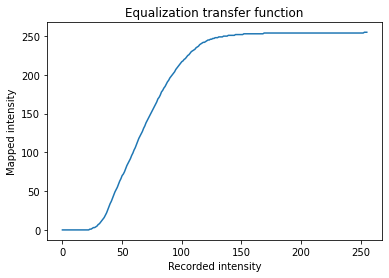

In [15]:
# Rescale to 0,255:
cdf_r = (np.array((cdf))*255.0).astype('uint8')
plt.plot(np.arange(0,256,1),cdf_r)
plt.title("Equalization transfer function")
plt.xlabel("Recorded intensity")
plt.ylabel("Mapped intensity")
plt.show()

##### Compensation transfer function
The result of applying transfer function `f(I) = c(I)` is **flat** (a lack of contrast and being muddy looking).<br>
One way to compensate for this is to only **partially compensate** for the histogram unevenness with a **coefficient**, e.g., by using a mapping function `f(I) = alpha*c(I)+(1-alpha)I`. 

In [16]:
# compensation transfer function
# f(I) = alpha*c(I)+(1-alpha)I
def compensation_fun(cdf,alpha):
    ctf = []
    for i in range(0,256):
        ctf.append(alpha*cdf[i]+(1-alpha)*i)
    plt.plot(np.arange(0,256),ctf,label = "alpha = "+str(alpha))
    plt.title("transfer function with alpha = "+str(alpha))
    plt.xlabel("Recorded intensity")
    plt.ylabel("Mapped intensity")
    plt.legend()
    plt.show()
    return ctf

As we can see below, the resulting image **maintains more of its original grayscale distribution** and has a more appealing balance when the **alpha** is smaller.

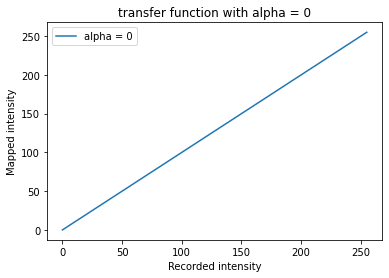

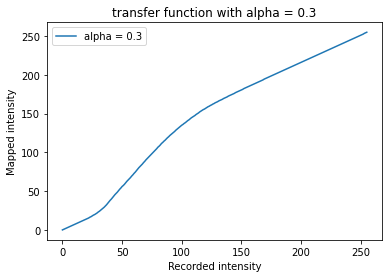

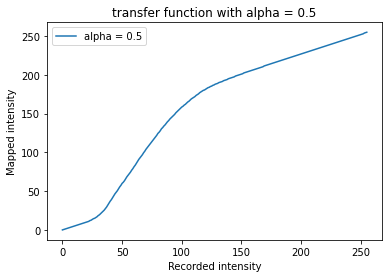

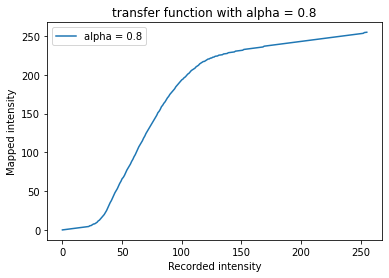

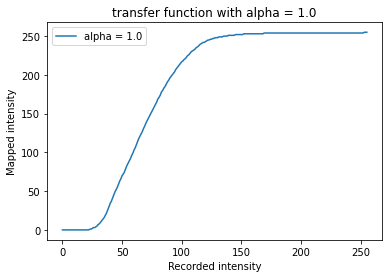

In [17]:
alphaa = [0,0.3,0.5,0.8,1.0]
for i in range(len(alphaa)):
    compensation_fun(cdf_r,alphaa[i])

#### Q3: (Optional) Try to increase the "punch" in the image by ensuring that a certain fraction of pixel (say, 5%) are mapped to pure black and white.
---

##### Probability density function
It's important to figure out the **ratio** of the number of pixels of a certain luma to the total pixels in the img.

In [18]:
# probability density function
def PDF(hist):
    sum = np.sum(hist)
    pdf = []
    for i in range(0,256):
        pdf.append(hist[i]/sum)
    plt.plot(np.arange(0,256,1),pdf)
    plt.title("PDF")
    plt.xlabel("Recorded intensity")
    plt.ylabel("probability")
    plt.show()
    return np.array(pdf)

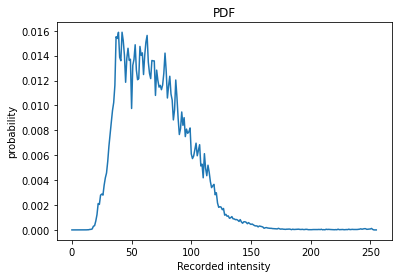

In [19]:
pdf = PDF(hist)

When a fraction **p** is given, find the two luminance values *black* and *white* corresponding to **p/2** or **1-p/2** at both ends of the **cumulative distribution function**, map the luminance value greater than *white* to `255` and the luminance value less than *black* to `0`.

In [20]:
def Pure_map(cdf,img_gray,p):
    img_pure = np.array(img_gray) # copy
    # map to pure white
    w_gray = np.where(cdf>=1-p/2)# luminance
    w_gray = w_gray[0].tolist()
    for i in w_gray: 
        res = np.where(img_gray==i)
        if len(res)==0:
            continue
        x,y = res
        for j in range(len(x)):
            img_pure[x[j]][y[j]] = 255
    # map to pure black
    b_gray = np.where(cdf<=p/2)# luminance
    b_gray = b_gray[0].tolist()
    for i in b_gray:
        res = np.where(img_gray==i)
        if len(res)==0:
            continue
        x,y = res
        for j in range(len(x)):
            img_pure[x[j]][y[j]] = 0
    return img_pure

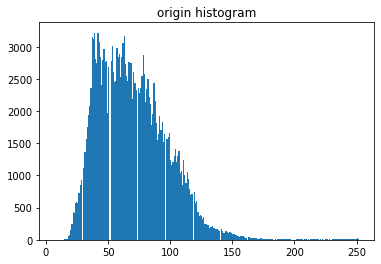

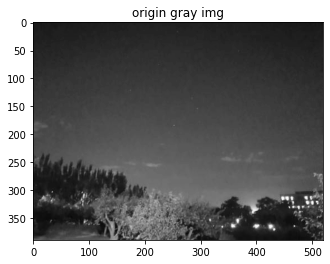

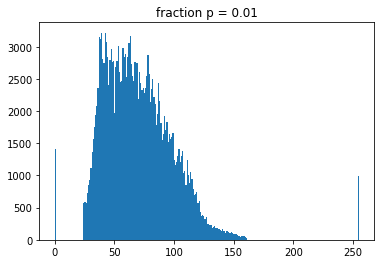

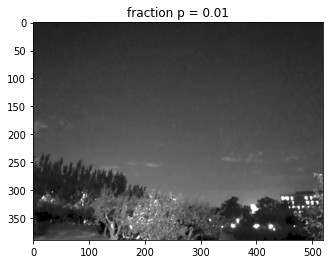

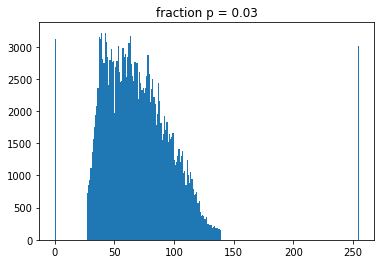

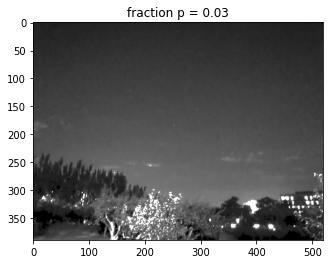

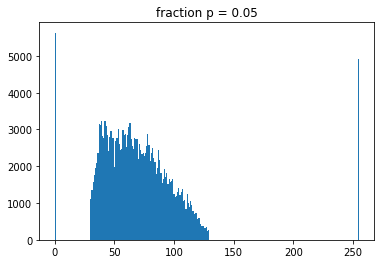

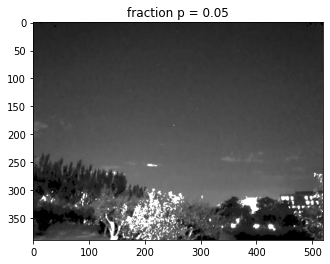

In [21]:
# show:
pure_fraction = [0.01,0.03,0.05]
plt.hist(img_gray.ravel(),256)
plt.title("origin histogram")
plt_show("origin gray img",img_gray,cmap="gray")
for i in pure_fraction:
    img_pure = Pure_map(cdf,img_gray,i)
    fig = plt.figure()
    _ = plt.hist(img_pure.ravel(),256)
    plt.title("fraction p = "+str(i))
    plt_show("fraction p = "+str(i),img_pure,cmap="gray")

#### Q4: (Optional) Limit the local gain ***f'(I)*** in the transfer function. One way to do this is to limit ***f(I) < yI*** or ***f'(I) < y*** while performing the accumulation (3.9), keeping any unaccumulated values **"in reserve"**.
---

##### Contrast Limited HE:
- Idea:
We can set a **threshold** for **probability**, and distributions over the threshold value are **spread evenly** over the probability density distribution.
- Steps:
Given a **local gain maximum *gamma***, find the **threshold *beta*** of the probability density distribution.<br>
- Code Implementation: **Binary Search** for ***beta*** value.


In [22]:
# cut_i: find out the luma values whose corrsponding probabilitiy valus are over threshold beta.
# cut_square: unaccumulated values are in reserve
def contrast_clipping(pdf,beta):
    pdf_c = np.array(pdf) # copy
    cut_i = np.where(pdf>beta)
    cut_i = cut_i[0] # only axis = 0
    cut_square = 0
    for i in cut_i:
        cut_square+=pdf[i]-beta
        pdf_c[i] = beta
    return pdf_c,cut_square

In [23]:
# Binary Search:
# find out the threshold beta.
def binary_search(gamma,pdf):
    l,r = 0,gamma
    beta = gamma
    while(r-l>0.00001):
        mid = (l+r)/2
        pdf_c,cut_square = contrast_clipping(pdf,mid)
        max = np.max(pdf_c+cut_square/256)
        if gamma-max>0.0001:
            l = mid
        elif gamma-max<0:
            r = mid
        else:
            beta = mid
            break
    pdf_c,cut_square = contrast_clipping(pdf,beta)

    return pdf_c,cut_square,beta
    

In [24]:
# show: 
# initial pdf - blue
# being cut without unaccumulated pdf - orange
# being cut with unaccumulated pdf - green
# local gain limit gamma - red
def contrast_clipping_img(gamma,pdf,pdf_c,cut_square,beta):
    plt.plot(np.arange(0,256,1),pdf,label = "initial pdf",color = "steelblue")
    plt.plot(np.arange(0,256,1),pdf_c,label = "cut pdf",color = "orange")
    plt.plot(np.arange(0,256,1),pdf_c+cut_square/256,label = "cut+unaccumulated pdf",color = "green")
    plt.plot(np.arange(0,256,1),[gamma]*256,label = "local gain limit",color = "red")
    plt.title("bata = "+str(beta))
    plt.legend()
    plt.show()

beta =  0.009218750000000001


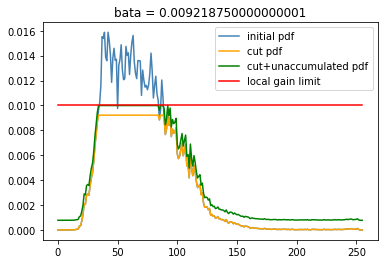

In [25]:
# show:
gamma = 0.01
pdf_c,cut_square,beta =  binary_search(gamma,pdf)
print("beta = ",str(beta))
contrast_clipping_img(gamma,pdf,pdf_c,cut_square,beta)

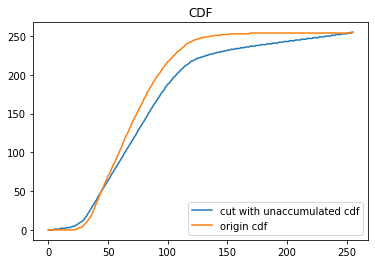

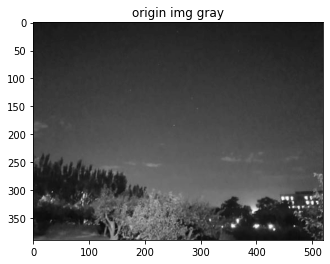

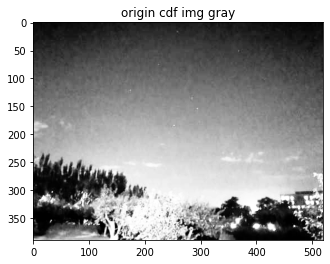

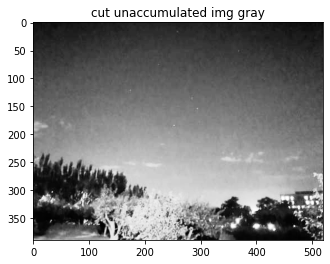

In [26]:
# re-generate image with new pdf:
cut_unaccu_pdf = pdf_c+cut_square/256
cut_unaccu_cdf = []
for i in range(0,256):
    cut_unaccu_cdf.append(np.sum(cut_unaccu_pdf[0:i+1]))
cut_unaccu_cdf = np.array(cut_unaccu_cdf)*255.0
cut_unaccu_cdf = int2uint(cut_unaccu_cdf)
plt.plot(np.arange(0,256,1),cut_unaccu_cdf,label = "cut with unaccumulated cdf")
plt.plot(np.arange(0,256,1),cdf_r,label = "origin cdf")
plt.title("CDF")
plt.legend()
img_cut_unaccu = cv2.LUT(src=img_gray,lut=cut_unaccu_cdf)
img_origincdf = cv2.LUT(src=img_gray,lut = cdf_r)
plt_show("origin img gray",img_gray,cmap="gray")
plt_show("origin cdf img gray",img_origincdf,cmap="gray")
plt_show("cut unaccumulated img gray",img_cut_unaccu,cmap="gray")

#### Q5: Compensate the luminance channel through the lookup table and re-generate the color image using color ratios(2.116).
---

##### lookup table(LUT):
Get the output by **looking up the table** instead of calculating it.<br>
And the table can be defined ahead.<br>
about lookup table:<https://ww2.mathworks.cn/help/simulink/ug/about-lookup-table-blocks.html> <br>
open-cv: output = cv2.LUT(src,lut) can fill the output array with values from the look-up table.

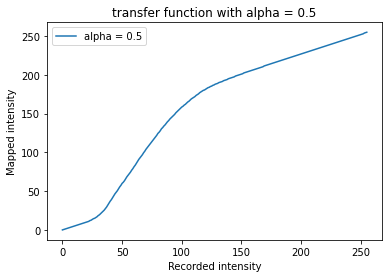

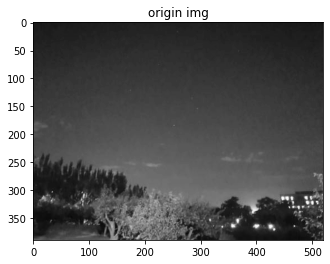

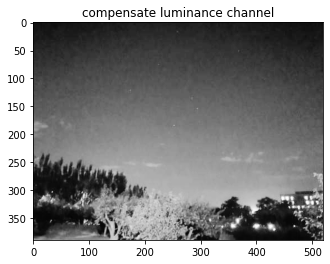

In [27]:
# Compensate the luminance channel: with Q.2 compensate transfer function:
# look up table:
alpha = 0.5
compen_cdf = compensation_fun(cdf_r,alpha) # f(I) = alpha*C(I)+(1-alpha)*I
compen_cdf = np.array(compen_cdf).astype('uint8')
# transfer:
transf_dst = cv2.LUT(src=img_gray,lut=compen_cdf)
plt_show("origin img",img_gray,cmap="gray")
plt_show("compensate luminance channel",transf_dst,cmap = "gray")

##### Re-generate color image using color ratios.
- (2.116): **color ratio: `r = R/(R+G+B)`**<br>
- new **r:g:b** = old **r:g:b** * (new **Y'**)/(old **Y'**) <br>

Given the original image, calculate the color image after manipulating luminance.<br>
Knowing the **old RGB color ratio** of the original image, **Y' of the original image and the new Y'**, the **new RGB color ratio** and the **new R+B+G** can be calculated, and finally the respective values of **R, B, and G** can be found.

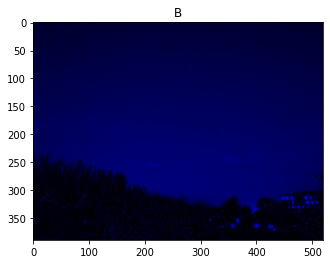

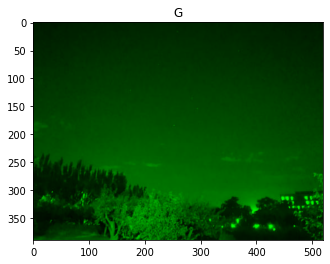

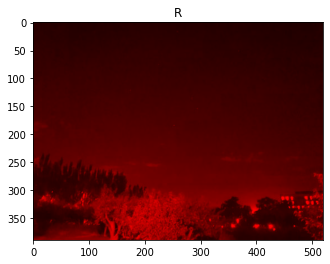

In [28]:
# split color channel:
b0,g0,r0 = cv2.split(img)
zeros = np.zeros((img.shape[:2]),dtype='uint8')
B_imgg = cv2.merge([zeros,zeros,b0])
G_imgg = cv2.merge([zeros,g0,zeros])
R_imgg = cv2.merge([r0,zeros,zeros])
plt_show("B",B_imgg)
plt_show("G",G_imgg)
plt_show("R",R_imgg)
# change to int:
b0 = np.array(b0,dtype = 'int')
r0 = np.array(r0,dtype = 'int')
g0 = np.array(g0,dtype = 'int')

In [29]:
# old B+G+R and old color ratio:
BGR_img = b0+r0+g0 
# ratio:
b_ratio = b0/BGR_img 
g_ratio = g0/BGR_img 
r_ratio = r0/BGR_img 

# luminance ratio:
l_ratio = transf_dst/img_gray
# new ratio:
nb_ratio = b_ratio*l_ratio
ng_ratio = g_ratio*l_ratio
nr_ratio = r_ratio*l_ratio
# according to Y' luminace = 0.299*R+0.587*G+0.114*B
luma_equ = 0.299*nr_ratio+0.587*ng_ratio+0.114*nb_ratio
# new R'+G'+B'
BGR_imgg = np.zeros((luma_equ.shape))
BGR_imgg[np.where(luma_equ!=0)] = np.array(transf_dst)[np.where(luma_equ!=0)]/luma_equ[np.where(luma_equ!=0)]
BGR_imgg[np.where(luma_equ==0)] = 0

In [30]:
# new R,G,B:
r1 = np.array(BGR_imgg*nr_ratio)
g1 = np.array(BGR_imgg*ng_ratio)
b1 = np.array(BGR_imgg*nb_ratio)

In [31]:
# transfer from int to uint8
r1u = int2uint(r1)
g1u = int2uint(g1)
b1u = int2uint(b1)

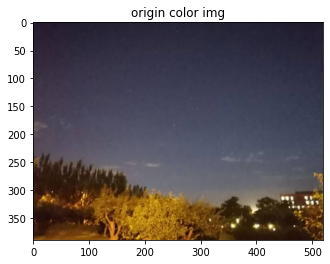

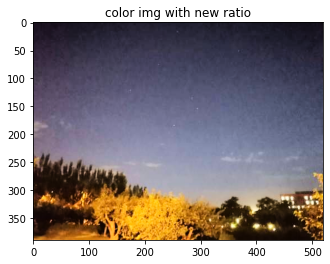

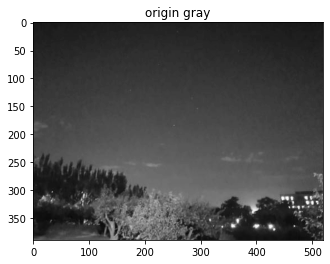

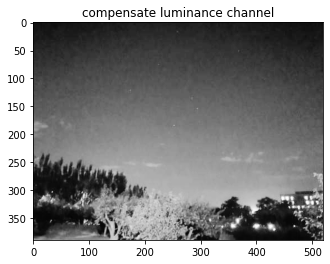

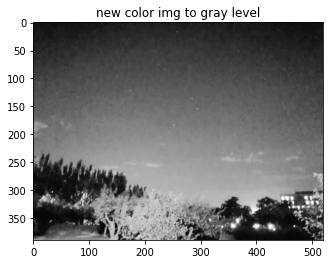

In [32]:
# show:
new_rgb = cv2.merge([r1u,g1u,b1u])
plt_show("origin color img",cv2.merge([r0,g0,b0]))
plt_show("color img with new ratio",new_rgb)
plt_show("origin gray",img_gray,cmap="gray")
plt_show("compensate luminance channel",transf_dst,cmap="gray")
plt_show("new color img to gray level",cv2.cvtColor(new_rgb,cv2.COLOR_RGB2GRAY),cmap="gray")

#### Q6: (Optional) Color values that are clipped in the original image, i.e., have one or more saturated color channels, may appear unnatural when remapped to a non-clipped value. Extend your algorithm to handle this case in some useful way.
---
- Idea: Use some tricks to ensure that the color values can be restored to a value greater than 255 after it has been clipped.<br>
- Compress: cv.NORM_MINMAX
```
minmax Normalize = (new_max-new_min)*((x-old_min)/(old_max-old_min))+new_min
```
Set the max and min values of the target array and transfer the original array to the target array in the range 0-255.<br>
- Revert: record the max and min values of the original array and use the formula above to remap to non-clipped value. 

In [33]:
# Compress to 0-255:
def Compress(array):
    c_array = np.zeros((array.shape))
    cv2.normalize(array,c_array,0,255,cv2.NORM_MINMAX)
    c_array = cv2.convertScaleAbs(c_array) # transfer to uint8
    return c_array

In [34]:
# Revert to non-clipped values:
# min max values of the original array
def Revert(array,min,max):
    new_min = 0
    new_max = 255
    n_array = np.zeros((array.shape))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            n_array[i][j] = (array[i][j]-new_min)*(max-min)/(new_max-new_min)+min
    return n_array
    

In [35]:
# Compress
r1c = Compress(r1)
g1c = Compress(g1)
b1c = Compress(b1)

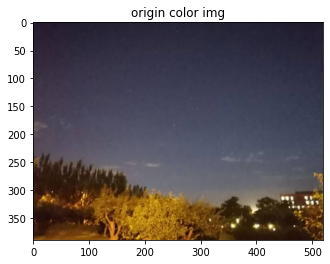

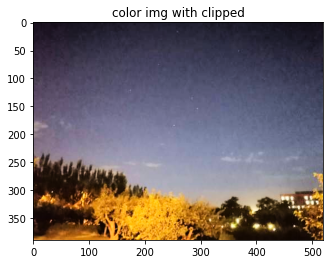

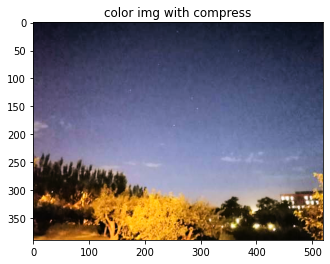

In [36]:
# show:
new_rgbb = cv2.merge([r1c,g1c,b1c])
plt_show("origin color img",cv2.merge([r0,g0,b0]))
plt_show("color img with clipped",new_rgb)
plt_show("color img with compress",new_rgbb)

In [37]:
# Revert:
r1r = Revert(r1c,np.min(r1),np.max(r1))
g1r = Revert(g1c,np.min(g1),np.max(g1))
b1r = Revert(b1c,np.min(b1),np.max(b1))

As you can see from the following results, the color values of the three rgb channels recovered using **minmax normalization** are not very different from the original color values

In [38]:
# Reversibility validation:
print("differences between r1 and r1 revert")
print((r1-r1r))
print(np.where(r1-r1r>1))
print("differences between g1 and g1 revert")
print(np.where(g1-g1r>1))
print("differences between b1 and b1 revert")
print(np.where(b1-b1r>1))

differences between r1 and r1 revert
[[ 0.44087209  0.44087209  0.44087209 ...  0.20700331  0.17935514
   0.05333646]
 [ 0.44087209  0.44087209  0.44087209 ...  0.20700331  0.08818322
   0.05333646]
 [ 0.44087209  0.44087209  0.44087209 ...  0.31941608  0.20700331
   0.08818322]
 ...
 [-0.40257601  0.15888094  0.43208779 ... -0.25591615  0.09860018
  -0.02174115]
 [-0.23564393  0.16436415 -0.03746468 ... -0.03765161 -0.18412114
  -0.28596647]
 [ 0.17153664  0.20879592  0.00788897 ...  0.4376018  -0.1076615
   0.0333188 ]]
(array([], dtype=int64), array([], dtype=int64))
differences between g1 and g1 revert
(array([], dtype=int64), array([], dtype=int64))
differences between b1 and b1 revert
(array([], dtype=int64), array([], dtype=int64))
